In [1]:
# Imports

import math, pickle, os, copy, sys, scipy.io, json, datetime

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

from numpy import random
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# Add the project directory to the path
PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from utils_pv import *
from samples.data_sim import PVDataset

#### FL
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from trainer import Trainer
from models import *
from metrics import mse

# Set the random seed
random_seed = 46
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)

# Set the device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = 'mps'

months_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

plt.rcParams.update({'font.size': 18})

In [2]:
# Generate data

NUM_CLIENTS=40

train_columns = ['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1']

hour_begin, hour_end = 8, 18

city_names = ['Lausanne']

# env_dict = {'city_names':city_names,
#             'num_clients': NUM_CLIENTS, 'num_modes': len(city_names),
#             'tilt_std': 5, 'az_std': 5, 'weather_dev':0.1,
#             'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':0.3,
#             'module_name': get_available_modules('sandia')[0:NUM_CLIENTS], #['Canadian_Solar_CS5P_220M___2009_'],
#             'inverter_name': get_available_inverters('cec')[0:NUM_CLIENTS], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
#             'lags':[1], 'months':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'hours':np.arange(hour_begin, hour_end), 
#             'train_scenarios':{'1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019}}}
# env_dict = PVDataset(env_dict).generate_clients_data()

# Load pickle
# env_dict = pickle.load(open('env_dict.pkl', 'rb'))
env_dict = pickle.load(open('env_dict_morevariation.pkl', 'rb'))

time_series = []

for client_ in range(NUM_CLIENTS):
    time_series_ = env_dict['train_scenarios']['1y']['time_series'][client_]

    # Remove nights
    time_series_ = time_series_[time_series_['hour_day'].isin(np.arange(hour_begin, hour_end))]

    # Add column day_of_month using column time
    time_series_['day'] = time_series_['time'].dt.day

    # Reorder columns
    time_series_ = time_series_[['time', 'year', 'month', 'day', 'hour_day', 'H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1', 'target']]

    time_series.append(time_series_)

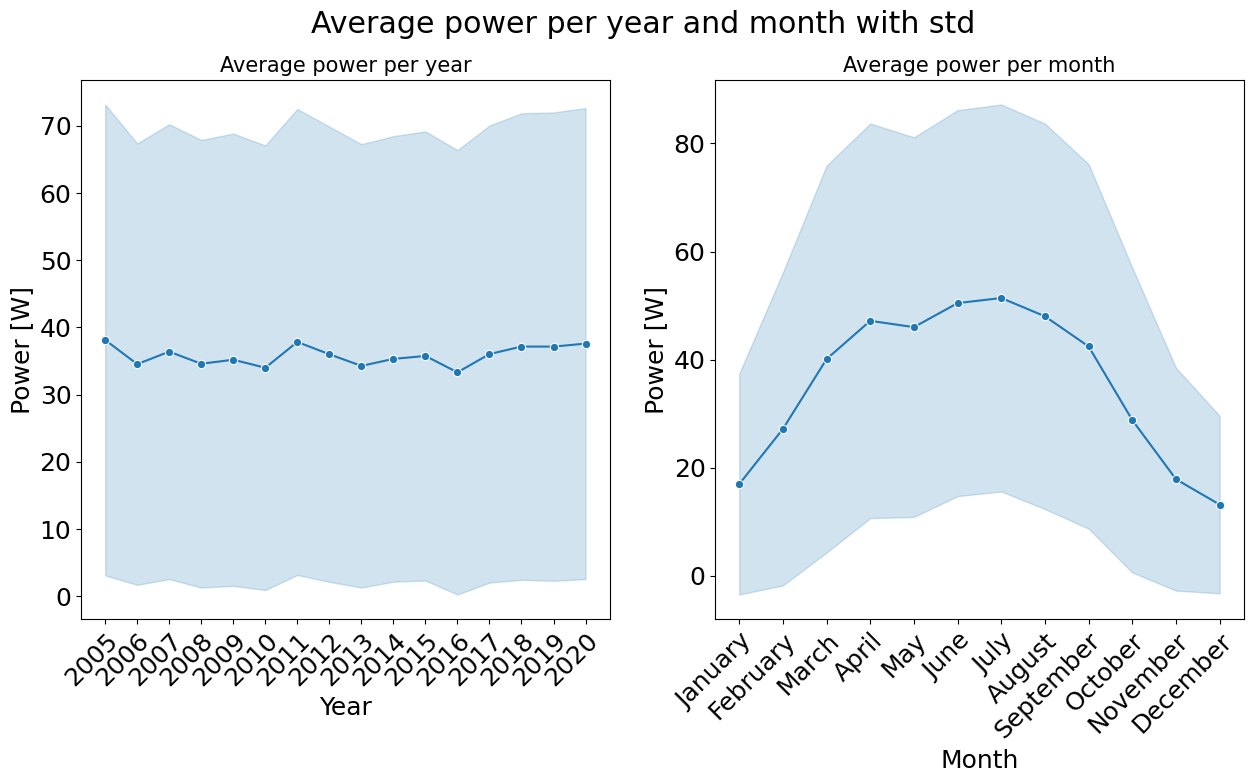

In [3]:
# plot with errorbar the avg and std of the target for each year
plt.figure(figsize=(15, 7))
plt.suptitle('Average power per year and month with std')
plt.subplot(1, 2, 1)
sns.lineplot(x='year', y='target', data=time_series[0], ci='sd', marker='o')
plt.title('Average power per year', fontsize=15)
plt.ylabel('Power [W]')
plt.xlabel('Year')
# plt.xticks(np.arange(2005, 2021), rotation=45)
plt.xticks(np.arange(2005, 2021), rotation=45, ha='right',rotation_mode='anchor')
plt.subplot(1, 2, 2)
sns.lineplot(x='month', y='target', data=time_series[0], ci='sd', marker='o')
plt.xlabel('Month')
# plt.xticks(np.arange(1, 13), [months_name[i] for i in np.arange(1, 13)], rotation=45) 
plt.xticks(np.arange(1, 13), [months_name[i] for i in np.arange(1, 13)], rotation=45, ha='right',rotation_mode='anchor')
plt.ylabel('Power [W]')
plt.title('Average power per month', fontsize=15)
plt.show()

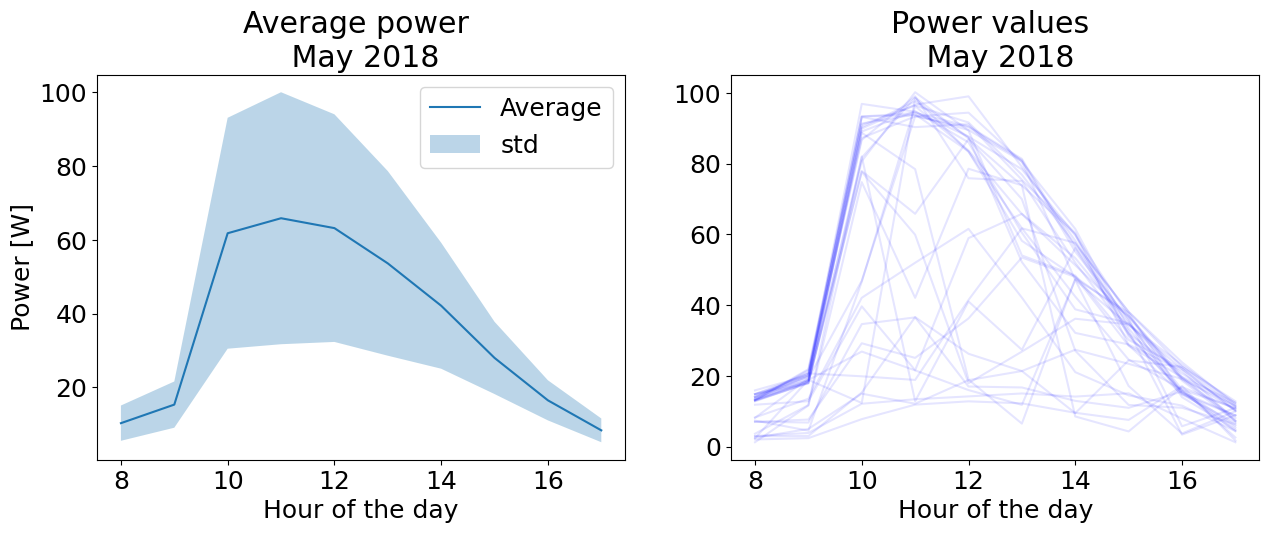

In [4]:
selected_year = 2018
selected_month = 5

client_num = 10

power_values = time_series[client_num][(time_series[client_num].year == selected_year) & (time_series[client_num].month == selected_month)]['target'].values
time_values = time_series[client_num][(time_series[client_num].year == selected_year) & (time_series[client_num].month == selected_month)]['hour_day'].values

# Plot the power values for a specific month
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.mean(time_values.reshape(-1, (hour_end-hour_begin)), axis=0), np.mean(power_values.reshape(-1, (hour_end-hour_begin)), axis=0), label='Average')
plt.fill_between(np.mean(time_values.reshape(-1, (hour_end-hour_begin)), axis=0), np.mean(power_values.reshape(-1, (hour_end-hour_begin)), axis=0) - np.std(power_values.reshape(-1, (hour_end-hour_begin)), axis=0), np.mean(power_values.reshape(-1, (hour_end-hour_begin)), axis=0) + np.std(power_values.reshape(-1, (hour_end-hour_begin)), axis=0), alpha=0.3, label='std')
plt.title('Average power \n {} {}'.format(months_name[selected_month], selected_year))
plt.xlabel('Hour of the day')
plt.ylabel('Power [W]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(np.mean(time_values.reshape(-1, (hour_end-hour_begin)), axis=0), power_values.reshape(-1, (hour_end-hour_begin)).T, color='blue', alpha=0.1)
plt.title('Power values \n {} {}'.format(months_name[selected_month], selected_year))
plt.xlabel('Hour of the day')
plt.show()

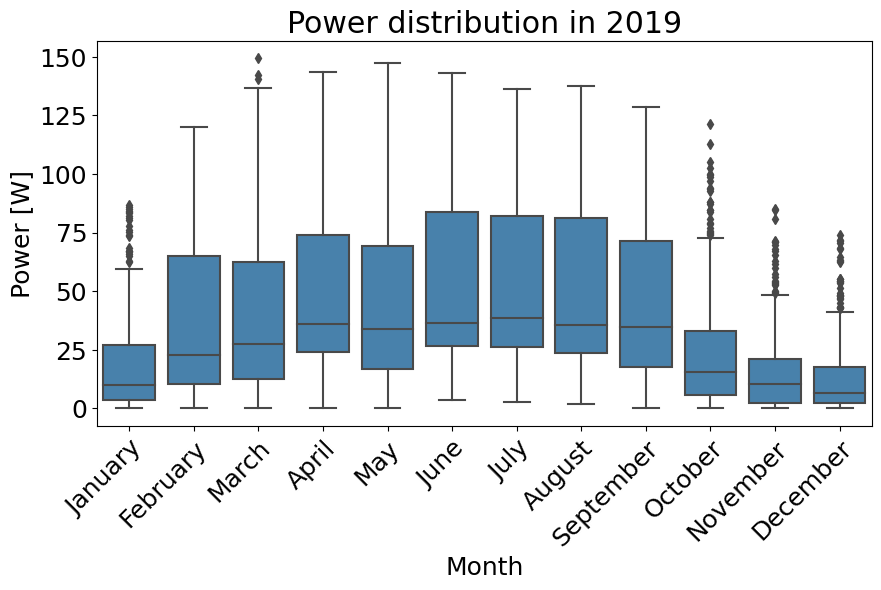

In [5]:
# plot the average power for each month of a year
year = 2019

fig, ax = plt.subplots(figsize=(10, 5))
fig = sns.boxplot(x='month', y='target', data=time_series[0][time_series[0].year==year], color='#3883bb')
plt.ylabel('Power [W]')
plt.xlabel('Month')
plt.title('Power distribution in {}'.format(year))
plt.xticks(np.arange(0, 12), [months_name[i] for i in np.arange(1, 13)], rotation=45, ha='right',rotation_mode='anchor')
plt.show()

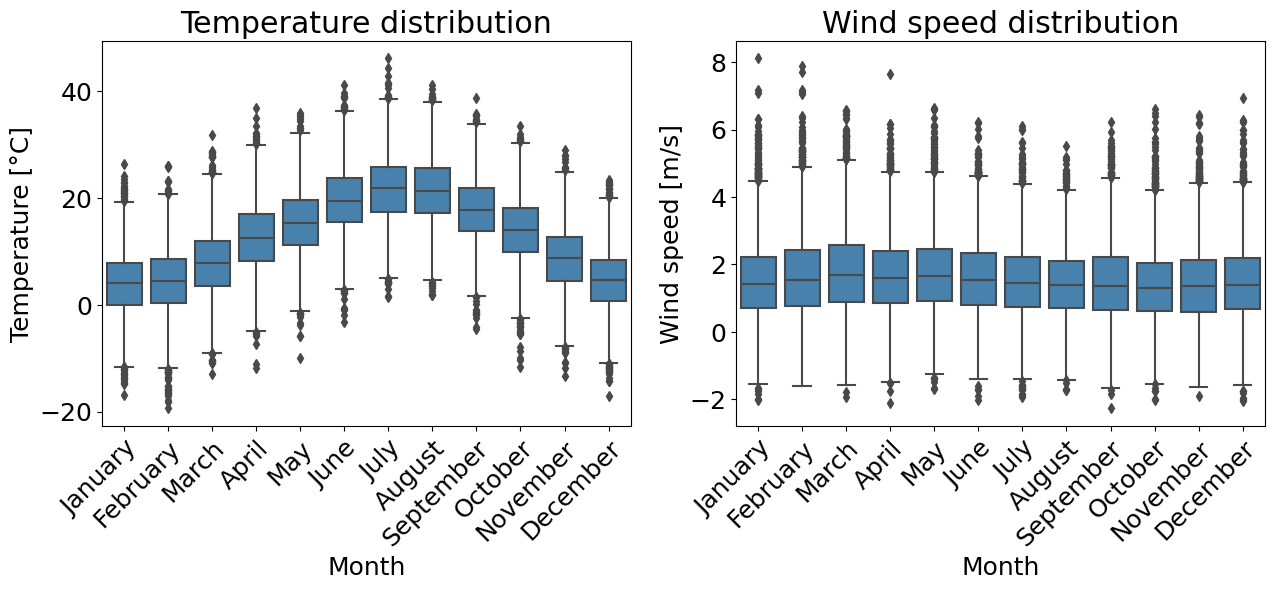

In [6]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.boxplot(x='month', y='T2m', data=time_series[0], color='#3883bb')
plt.ylabel('Temperature [°C]')
plt.xticks(np.arange(0, 12), [months_name[i] for i in np.arange(1, 13)], rotation=45, ha='right',rotation_mode='anchor')
plt.xlabel('Month')
plt.title('Temperature distribution')

plt.subplot(1,2,2)
sns.boxplot(x='month', y='WS10m', data=time_series[0], color='#3883bb')
plt.ylabel('Wind speed [m/s]')
plt.xticks(np.arange(0, 12), [months_name[i] for i in np.arange(1, 13)], rotation=45, ha='right',rotation_mode='anchor')
plt.xlabel('Month')
plt.title('Wind speed distribution')
plt.show()

### 1. Visualize the data for multiple households

In [7]:
# Generate data

months_name = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

NUM_CLIENTS=40

train_columns = ['H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1']

hour_begin, hour_end = 8, 18

city_names = ['Lausanne']

# env_dict = {'city_names':city_names,
#             'num_clients': NUM_CLIENTS, 'num_modes': len(city_names),
#             'tilt_std': 5, 'az_std': 5, 'weather_dev':0.1,
#             'irrad_std':0.2, 'altitude_dev':0.1, 'shadow_peak_red':0.3,
#             'module_name': get_available_modules('sandia')[0:NUM_CLIENTS], #['Canadian_Solar_CS5P_220M___2009_'],
#             'inverter_name': get_available_inverters('cec')[0:NUM_CLIENTS], # ['ABB__MICRO_0_25_I_OUTD_US_208__208V_'],
#             'lags':[1], 'months':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'hours':np.arange(hour_begin, hour_end), 
#             'train_scenarios':{'1y':{'m_train':None, 'train_years':[2018], 'valid_years':2019}}}
# env_dict = PVDataset(env_dict).generate_clients_data()

# Read pickle
env_dict = pickle.load(open('env_dict_morevariation.pkl', 'rb'))

time_series = []

for client_ in range(NUM_CLIENTS):
    time_series_ = env_dict['train_scenarios']['1y']['time_series'][client_]

    # Remove nights
    time_series_ = time_series_[time_series_['hour_day'].isin(np.arange(hour_begin, hour_end))]

    # Add column day_of_month using column time
    time_series_['day'] = time_series_['time'].dt.day

    # # Reorder columns
    time_series_ = time_series_[['time', 'year', 'month', 'day', 'hour_day', 'H_sun', 'T2m', 'WS10m', 'hourofd_x', 'hourofd_y', 'dayofy_x', 'dayofy_y', 'station_irrad_direct_prev', 'station_irrad_diffuse_prev', 'lag 1', 'target']]

    time_series.append(time_series_)

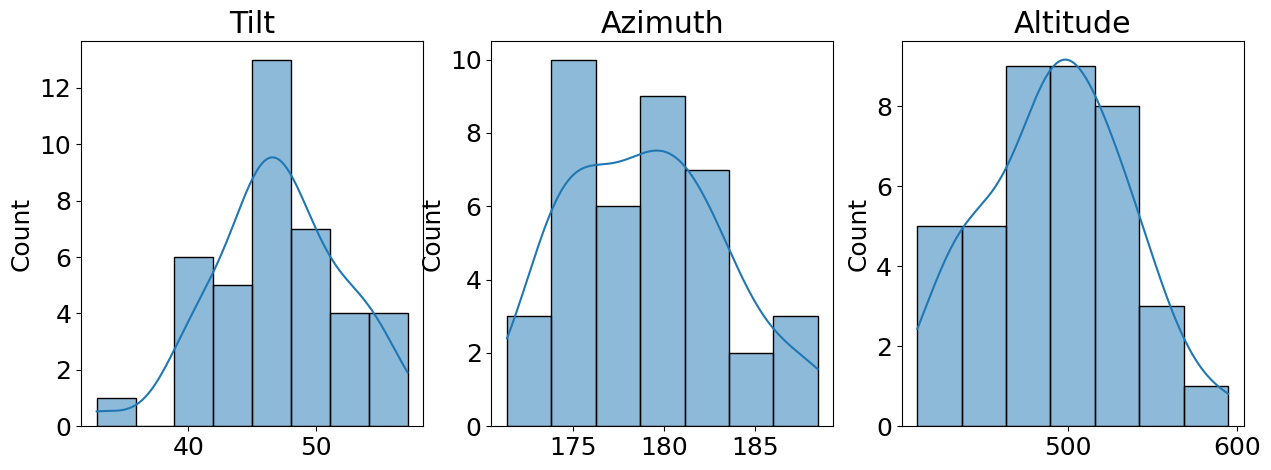

In [8]:
# print the information about clients_config 

if NUM_CLIENTS < 10:
    for client_ in range(NUM_CLIENTS):
        print(f'Client {client_} - Tilt: {env_dict["clients_config"]["tilt"][client_]:.2f} - Azimuth: {env_dict["clients_config"]["azimuth"][client_]:.2f} - Altitude: {env_dict["clients_config"]["altitude"][client_]:.2f}')
    print()    
    for client_ in range(NUM_CLIENTS):
        print(f'Client {client_} - Module: {env_dict["clients_config"]["module_name"][client_]} - Inverter: {env_dict["clients_config"]["inverter_name"][client_]}')
        
else:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    sns.histplot(env_dict["clients_config"]["tilt"], kde=True)
    plt.title('Tilt')
    plt.subplot(1, 3, 2)
    sns.histplot(env_dict["clients_config"]["azimuth"], kde=True)
    plt.title('Azimuth')
    plt.subplot(1, 3, 3)
    sns.histplot(env_dict["clients_config"]["altitude"], kde=True)
    plt.title('Altitude')

In [9]:
# for each client, normalize the column target by month
time_series_norm = []
for client_ in range(NUM_CLIENTS):
    time_series_norm_ = time_series[client_].copy()
    time_series_norm_['target'] = time_series_norm_.groupby(['year', 'month'])['target'].transform(lambda x: (x - x.mean()) / x.std())
    time_series_norm.append(time_series_norm_)

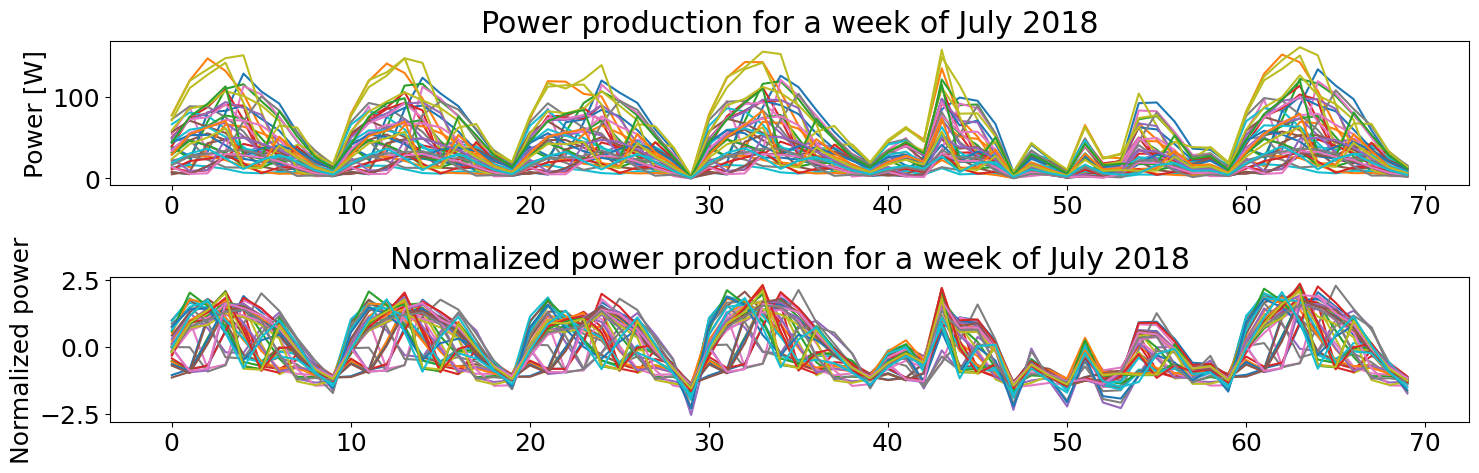

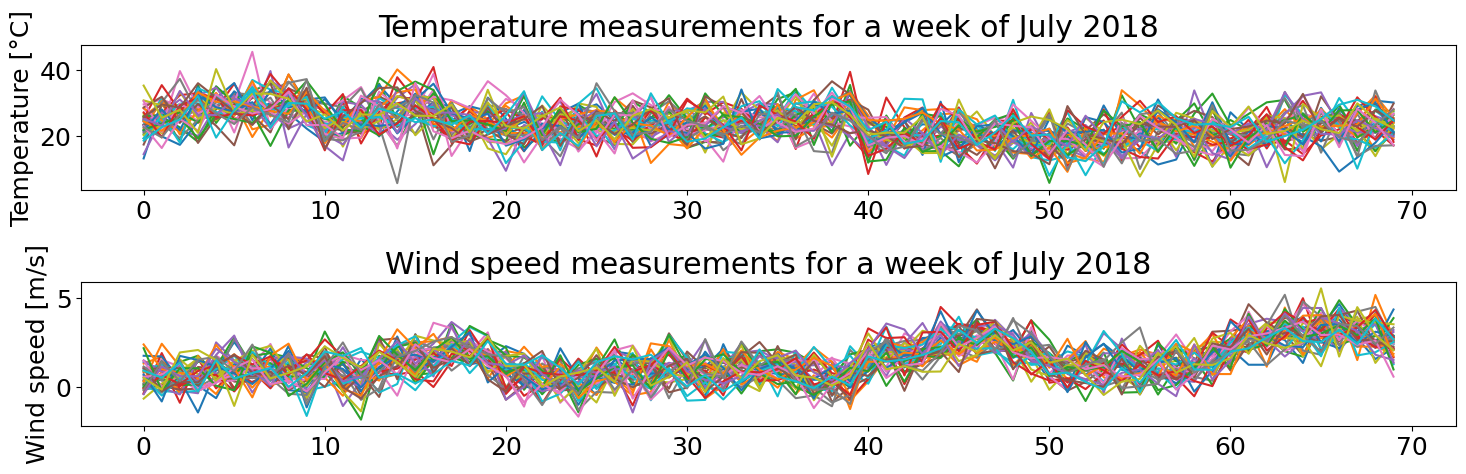

In [10]:
year = 2018
month = 7

# Power production
plt.figure(figsize=(15, 5))

# Power production
plt.subplot(2, 1, 1)
plt.ylabel('Power [W]')
plt.title('Power production for a week of {} {}'.format(months_name[month], year))
for client_ in range(NUM_CLIENTS):
    time_series_client = time_series[client_]
    plt.plot(time_series_client[(time_series_client['year']==year) & (time_series_client['month']==month) & (time_series_client['day'].isin(np.arange(1, 8)))]['target'].values, label='Client {}'.format(client_))
    
# Normalized power production
plt.subplot(2, 1, 2)
plt.ylabel('Normalized power')
plt.title('Normalized power production for a week of {} {}'.format(months_name[month], year))
for client_ in range(NUM_CLIENTS):
    time_series_client = time_series_norm[client_]
    plt.plot(time_series_client[(time_series_client['year']==year) & (time_series_client['month']==month) & (time_series_client['day'].isin(np.arange(1, 8)))]['target'].values, label='Client {}'.format(client_))
    
plt.tight_layout()
plt.show()

# Temperature and Wind speed
plt.figure(figsize=(15, 5))

# Temperature
plt.subplot(2,1,1)
plt.ylabel('Temperature [°C]')
plt.title('Temperature measurements for a week of {} {}'.format(months_name[month], year))
for client_ in range(NUM_CLIENTS):
    time_series_client = time_series[client_]
    plt.plot(time_series_client[(time_series_client['year']==year) & (time_series_client['month']==month) & (time_series_client['day'].isin(np.arange(1, 8)))]['T2m'].values, label='Client {}'.format(client_))
    
# Wind speed
plt.subplot(2,1,2)
plt.ylabel('Wind speed [m/s]')
plt.title('Wind speed measurements for a week of {} {}'.format(months_name[month], year))
for client_ in range(NUM_CLIENTS):
    time_series_client = time_series[client_]
    plt.plot(time_series_client[(time_series_client['year']==year) & (time_series_client['month']==month) & (time_series_client['day'].isin(np.arange(1, 8)))]['WS10m'].values, label='Client {}'.format(client_))
    
plt.tight_layout()
plt.show()